Equipment : R&S RTP084, 9.6 GHz Photodetector, Optical Diode

In [1]:
import os
import numpy as np

from scipy import stats

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

import pandas as pd
import glob
import natsort

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from RSRTxReadBin import RTxReadBin

/var/folders/hg/n17fww195g9887twwb23k9k40000gn/T/ipykernel_85791/3652459420.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


Text(0, 0.5, 'Detector (V)')

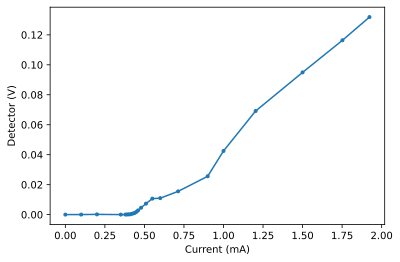

In [2]:
# Preparing the data according to notes.
path = 'data-sets/data-set-11/'
ds11_files = natsort.natsorted(glob.glob(path+ '/*.Wfm.bin'))
 
# Offsets for sensitivty of 2mV/div
offset_y, offset_x, offset_S = RTxReadBin(ds11_files[0])
offset = np.average(offset_y)

#ds9_mA = np.array([0,0.1,0.2,0.302,0.351,0.38,0.39,0.4,0.41,0.42,0.43,0.44,0.45,0.46,0.479,0.51,0.548,0.55,0.6,0.713,0.901,1.203,1.5,1.752,1.923])
ds9_mA = np.array([0,0.1,0.2,0.351,0.38,0.39,0.4,0.41,0.42,0.43,0.44,0.45,0.46,0.479,0.51,0.55,0.6,0.713,0.9,1,1.203,1.5,1.752,1.923])


avgs, stds, skews, kurts = np.array([]), np.array([]), np.array([]), np.array([])

def ds11_stats(file):
    y, x, S = RTxReadBin(file)
    y -= offset
    avg = np.average(y)
    std = np.std(y)
    skew = stats.skew(y)
    kurt = stats.kurtosis(y)
    return avg, std, skew, kurt

for file in ds11_files:
    avg, std, skew, kurt = ds11_stats(file)
    avgs = np.append(avgs, avg)
    stds = np.append(stds, std)
    skews = np.append(skews, skew)
    kurts = np.append(kurts, kurt)

plt.plot(ds9_mA, avgs, '.-')
plt.xlabel("Current (mA)")
plt.ylabel("Detector (V)")


In [4]:
print(ds9_mA[19:22])
print(stds[19:22])
print(ds9_mA[20])

[1.    1.203 1.5  ]
[0.00174888 0.00177363 0.00172834]
1.203


ValueError: object too deep for desired array

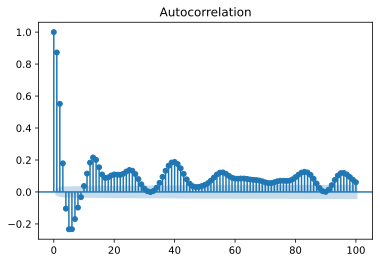

In [39]:
import statsmodels.api as sm

def ds11_trace(file):
    y, x, S = RTxReadBin(file)
    y -= offset
    #print(S)
    #plt.figure()
    #plt.plot(x[0:500],y.flat[0:500])
    #plt.figure()
    #plt.hist(y.flat[0:1000000],bins=100)
    #print('len',len(y.flat))
    y2 = y.flat[0:10000]
    #print(y.flat)
    sm.graphics.tsa.plot_acf(y2, lags=100)
    n = 1000
    a, v = np.correlate(x[0:n],y[0:n])
    plt.plot(a,v)
    return y, x
    
y, x = ds11_trace(ds11_files[23])
#y, x = ds11_trace(ds11_files[3])
#, x = ds11_trace(ds11_files[12])
#print(y[0])
plt.figure()
plt.plot(avgs[0:5])

In [120]:

def acf_manual(file):
    y, x, S = RTxReadBin(file)
    y -= offset
    y = y.flat[0:1000]
    
    lags = range(1000)
    acorr = len(lags) * [0]
    mean = sum(y) / len(y) 
    var = sum([(x - mean)**2 for x in y]) / len(y) 
    ndata = y - mean
    for l in lags:
        c = 1
        if (l > 0):
            tmp = [ndata[l:][i] * ndata[:-l][i] 
                for i in range(len(y) - l)]
            
            c = sum(tmp) / len(y) / var
        acorr[l] = c
    return acorr

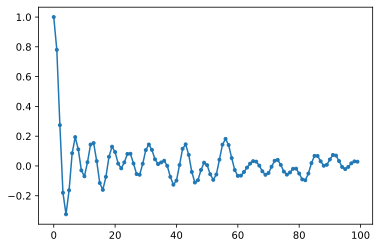

In [141]:
acf = acf_manual(ds11_files[3])
acf = np.array([acf])
plt.plot(acf.flat[0:100],'.-')
acf_2 = acf_manual(ds11_files[5])

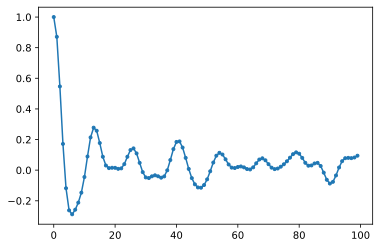

In [142]:
acf = acf_manual(ds11_files[23])
acf = np.array([acf])
plt.plot(acf.flat[0:100],'.-')
acf_2 = acf_manual(ds11_files[5])

In [269]:
g2_t_b = np.array([])
n = 100

y = y.flat[0:10000]


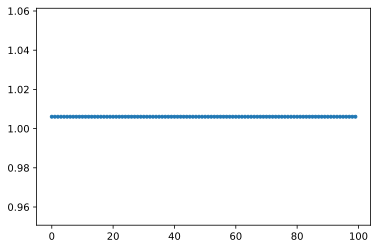

In [283]:
ans_n = np.array([])
g2_t_x=  np.array([])

for i in range(100):
    ys = y
    for i in range(100):
        ans_num = y[i]*y[i+n]
        ans_n = np.append(ans_n, ans_num)
    ans_den = np.average(y)**2
    ans = np.average(ans_n)/ans_den
    g2_t_x = np.append(g2_t_x,ans)

plt.plot(g2_t_x,'.')

In [296]:
def g2_of_tau_final(file):
    y, x, S = RTxReadBin(file)
    y -= offset
    y = y.flat[0:100000]
    return y

test_set = g2_of_tau_final(ds11_files[8])
test_set = test_set.flat

In [275]:
print(len(g2_t_b))

49901


In [160]:

def g2_of_tau_final(file):
    y, x, S = RTxReadBin(file)
    y -= offset
    y = y.flat[0:100000]
    
    t = 10

    g2_tau_arr = np.array([])
    
    for i in range(100):
        g2_tau = np.average(y[t:2*t]*y[t:])
        g2_tau_arr = np.append(g2_tau_arr, g2_tau)
        t += 10

    return g2_tau_arr

In [166]:
import qutip


def g2_of_tau_final_2(file):
    y, x, S = RTxReadBin(file)
    y -= offset
    y = y.flat[0:10000]
    
    g2 = np.array([])
    taus = np.linspace(0, len(y)/100, 100 )

    for tau in taus:
        g2_tau = 
        g2 = np.append(g2, g2_tau)

    return g2

    

g2_of_tau_final_2(ds11_files[23])


[-5.000000e-05 -4.999999e-05 -4.999998e-05 ...  4.999997e-05  4.999998e-05
  4.999999e-05]


In [221]:
def g2_tau(file, t):
    y, x, S = RTxReadBin(file)
    y -= offset
    n = t
    print(int(len(y)/n))
    g2 = np.array([])

    for i in range(int(len(y)/n)):
        g2_t = (np.average( np.average(y) * np.average(y[0:i*n])))/(np.average(y)**2)
        g2 = np.append(g2, g2_t)
    return g2


In [250]:
def g2_tau_ds11(file, t):
    y, x, S = RTxReadBin(file)
    y -= offset
    n = t
    print(int(len(y)/n))
    g2 = np.array([])

    for i in range(int(len(y)/n)):
        g2_t = ( np.average( y[] * y[i:i*n]))/(np.average(y)**2)
        g2 = np.append(g2, g2_t)
    return g2

In [251]:
g2_tau_ds10_o41 = np.array([])
g2_tau_ds10_o41 = np.append(g2_tau_ds10_o41, g2_tau_ds11(ds11_files[7], 10000))

1000


ValueError: operands could not be broadcast together with shapes (10000000,1,1) (0,1,1) 

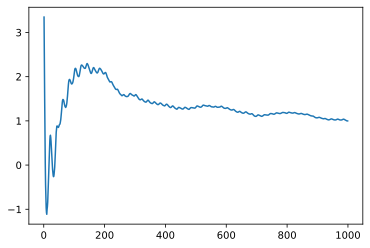

In [249]:
plt.plot(g2_tau_ds10_o41)

In [307]:
def pretty(d, indent=0):
   for key, value in d.items():
      print('\t' * indent + str(key))
      if isinstance(value, dict):
         pretty(value, indent+1)
      else:
         print('\t' * (indent+1) + str(value))

pretty(S)

SourceType
	eRS_SIGNAL_SOURCE_TYPE_SOURCE
Resolution
	1e-11
RecordLength
	10000000.0
HWRecordLength
	10000000.0
TriggerOffset
	0.0
RescaleCenterTime
	0.0
DecimationMode
	eRS_DECIMATION_MODE_SAMPLE
TraceArithmetics
	eRS_TRACE_ARITHMETICS_SINGLE
TraceType
	eRS_TRACE_TYPE_NORMAL
BaseUnit
	eRS_UNIT_LEVEL_V
BaseUnitRelative
	eRS_ONOFF_OFF
Impedance
	50.0
XStart
	-5e-05
XStop
	5e-05
SignalRecordLength
	10000000.0
HardwareXStart
	-5.000047e-05
HardwareXStop
	5.00005e-05
SignalHardwareRecordLength
	10000097.0
AdjustedResolutionBW
	0.0
NoiseBandwidth
	0.0
InterleavedTraceCount
	1.0
ValueType
	eRS_SIGNAL_VALUE_TYPE_COMPLETELY_FINITE_DEFINED
NofQuantisationLevels
	64768.0
DecimationFactor
	1.0
TOADone
	eRS_ONOFF_ON
ISO_TRG
	0.0
SC_POST
	0.0
SC_TRG
	0.0
SignalResolution
	1e-11
LeadingSettlingSamples
	47.0
TimeScale
	1e-05
ReferencePoint
	50.0
RescaleCenterPoint
	50.0
VerticalPosition
	0.0
VerticalScale
	0.003
VerticalOffset
	0.12384
BaseYStart
	0.10884
BaseYStop
	0.13884
ViewUnit
	eRS_UNIT_LEVEL_V

In [302]:
%pprint

Pretty printing has been turned ON


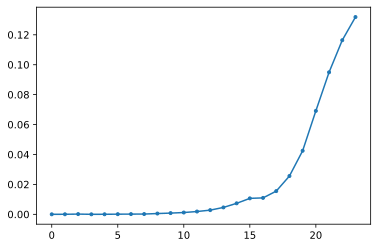

In [ ]:
plt.plot(avgs,'.-')

Text(0, 0.5, 'Standard deviation of Detector (V)')

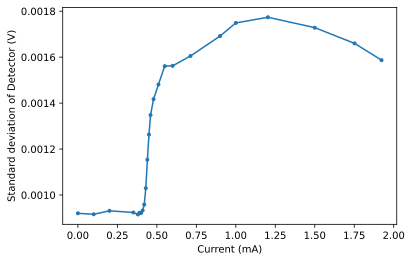

In [ ]:
plt.plot(ds9_mA,stds[0:26], '.-')
plt.xlabel("Current (mA)")
plt.ylabel("Standard deviation of Detector (V)")

Text(0, 0.5, 'Standard Deviation / Average')

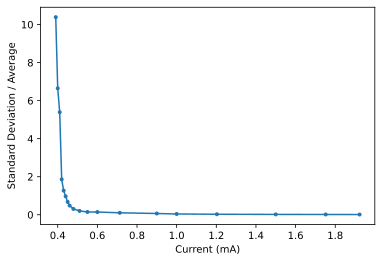

In [ ]:
plt.plot(ds9_mA[5:],stds[5:]/avgs[5:], '.-')
plt.xlabel("Current (mA)")
plt.ylabel("Standard Deviation / Average")

In [ ]:
plt.plot(ds9_mA[0:4],stds[5:]/avgs[0:4:], '.-')

ValueError: operands could not be broadcast together with shapes (19,) (4,) 

In [ ]:
avgs

array([-1.07526776e-09,  2.30574606e-05,  1.44137914e-04, -1.29150445e-04,
        1.19513629e-06,  2.35343341e-05,  8.88368013e-05,  1.38639007e-04,
        1.72969565e-04,  5.15246065e-04,  8.09682766e-04,  1.19002082e-03,
        1.86317915e-03,  2.79154791e-03,  4.59926622e-03,  7.34271249e-03,
        1.06618935e-02,  1.09753264e-02,  1.55160688e-02,  2.55956259e-02,
        4.22276370e-02,  4.24753316e-02,  6.91372752e-02,  9.49318856e-02,
        1.16372250e-01,  1.31860316e-01])

NameError: name 'S' is not defined

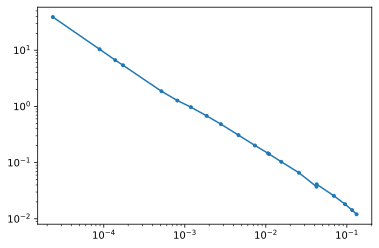

In [ ]:
x = 5
plt.loglog(avgs[x:],(stds[x:]/avgs[x:]),'.-')


In [ ]:
print(stds,avgs)

[0.00092041 0.00091626 0.00093131 0.0009336  0.00092407 0.00091543
 0.00092286 0.00092199 0.00093279 0.00095828 0.00102973 0.0011534
 0.00126314 0.00134817 0.00141707 0.0014811  0.00156086 0.00156228
 0.00160507 0.00169177 0.00157591 0.00174888 0.00177363 0.00172834
 0.00165992 0.00158691] [-1.07526776e-09  2.30574606e-05  1.44137914e-04 -1.29150445e-04
  1.19513629e-06  2.35343341e-05  8.88368013e-05  1.38639007e-04
  1.72969565e-04  5.15246065e-04  8.09682766e-04  1.19002082e-03
  1.86317915e-03  2.79154791e-03  4.59926622e-03  7.34271249e-03
  1.06618935e-02  1.09753264e-02  1.55160688e-02  2.55956259e-02
  4.22276370e-02  4.24753316e-02  6.91372752e-02  9.49318856e-02
  1.16372250e-01  1.31860316e-01]


[ 3.27056088e-02  3.52697782e-02  3.93645093e-02  5.73410727e-02
  4.91449460e-02  3.46437767e-02  4.67483141e-02  6.72410429e-02
  9.21247602e-02  1.53826341e-01  1.73163354e-01  1.23464040e-01
  5.29054143e-02 -1.51571510e-02 -1.06894290e-02  2.04082765e-02
  1.55392876e-02  4.84470231e-03  7.03764753e-03 -1.98937766e-03
  6.17549376e-05 -1.76448952e-02 -4.15309854e-02 -1.17933303e-01]


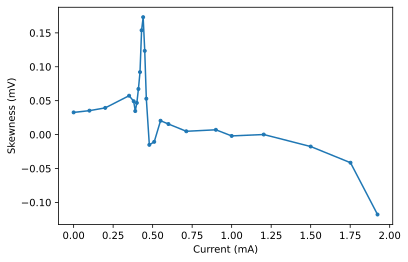

In [ ]:
plt.plot(ds9_mA, skews, '.-')
plt.xlabel("Current (mA)")
plt.ylabel("Skewness (mV)")

print(skews)

[ 0.01461315  0.02256775  0.01179886  0.013937    0.0164609   0.02269864
  0.01807237  0.02531433  0.04530907  0.06136394  0.09391141  0.03455305
 -0.00878739  0.0062511   0.08879447  0.10187912  0.03121114  0.02755427
  0.07409215  0.02828717  0.04888272  0.00858736  0.01164961  0.03426886
 -0.01656818]


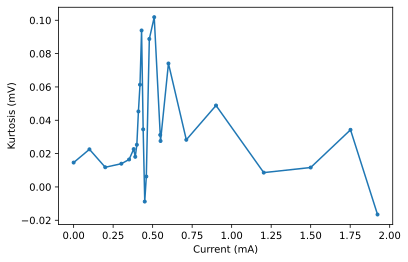

In [ ]:
plt.plot(ds9_mA, kurts, '.-')
plt.xlabel("Current (mA)")
plt.ylabel("Kurtosis (mV)")
print(kurts)

/var/folders/hg/n17fww195g9887twwb23k9k40000gn/T/ipykernel_38849/3587109770.py:4: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(ds9_mA,1/np.sqrt(avgs), '.-')


Text(0, 0.5, 'Relative Noise')

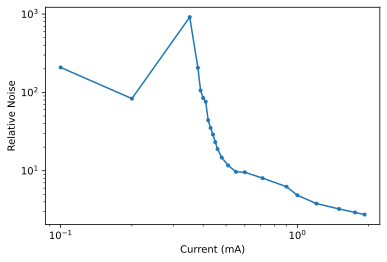

In [ ]:
# realtive noise 

plt.loglog()
plt.plot(ds9_mA,1/np.sqrt(avgs), '.-')
plt.xlabel("Current (mA)")
plt.ylabel("Relative Noise")

#print(ds9_mA,1/np.sqrt(avgs))

In [ ]:
def g2_function(file):
    y, x, S = RTxReadBin(file)
    y -= offset
    g2 = (np.sum(y**2)/(np.average(y)**2))/len(y)
    return g2

g2_array = np.array([])

for file in ds11_files:
    g2_array = np.append(g2_array, g2_function(file))

 

In [206]:
plt.plot(ds9_mA[8:],g2_array[8:],'.-')
plt.axhline(y=1)

NameError: name 'g2_array' is not defined

In [ ]:
print(ds9_mA[12:],g2_array[12:])
print(avgs[12:])
print(offset)

[0.46  0.479 0.51  0.55  0.6   0.713 0.9   1.    1.203 1.5   1.752 1.923] [1.23323613 1.0949316  1.04068708 1.02143214 1.02026154 1.01069895
 1.00436853 1.00169331 1.00065893 1.00033076 1.00020521 1.00014491]
[0.00279155 0.00459927 0.00734271 0.01066189 0.01097533 0.01551607
 0.02559563 0.04247533 0.06913728 0.09493189 0.11637225 0.13186032]
0.0026760858


In [ ]:
def g2_tau(file, t):
    y, x, S = RTxReadBin(file)
    y -= offset
    g2_tau = np.average(y[0:(len(y)-t)]*y[t:])/(np.average(y)**2)
    return g2_tau

In [ ]:
g2_arr, g2_tau_arr = np.array([]), np.array([])

for file in ds11_files:
    g2_arr, g2_tau_arr = np.append(g2_array, g2_tau(file,0)), np.append(g2_array, g2_tau(file,1))

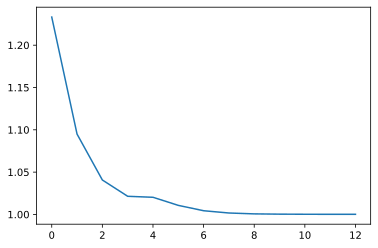

In [ ]:
plt.plot(g2_arr[12:])

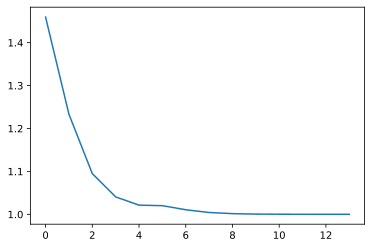

In [ ]:
plt.plot(g2_tau_arr[12:])

In [ ]:
print(len(y))

10000000


In [ ]:
g2_tau_arr_2 = np.array([])

for file in ds11_files:
    g2_tau_arr_2 = np.append(g2_array, g2_tau(file,100000000))

plt.plot(ds9_mA,g2_tau_arr_2[12:])

NameError: name 'g2_array' is not defined

In [ ]:
print(offset)

0.0026760858


In [ ]:
def g2_function(file):
    y, x, S = RTxReadBin(file)
    y -= offset
    
    g2 = np.array([])
    #g2 = (np.append(g2, y[i]*y[i+1]/(y[i]**2)))
    
    return g2

g2_function(ds11_files[1])

In [ ]:
import statsmodels.api as sm

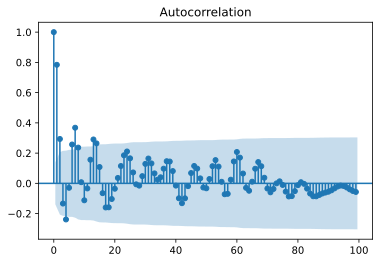

In [ ]:
# acf func

def plot_auto_corel(file):
    y, x, S = RTxReadBin(file)
    lenght = 100
    y -= offset 
    plt_y = y[0:lenght]
    plt_y = np.append(plt_y, np.zeros(lenght))
    #lag = len(y)
    sm.graphics.tsa.plot_acf(plt_y, lags= lenght - 1)
    plt.show()
    
plot_auto_corel(ds11_files[3])

Current 0.45  Skewness : [[0.05290008]]  Kurtosis : [[0.0062511]]
Current 0.46  Skewness : [[-0.01516182]]  Kurtosis : [[0.08879447]]
Current 0.479  Skewness : [[-0.01072423]]  Kurtosis : [[0.10187912]]
Current 0.51  Skewness : [[0.02039219]]  Kurtosis : [[0.03120804]]
Current 0.548  Skewness : [[0.01551426]]  Kurtosis : [[0.02755117]]


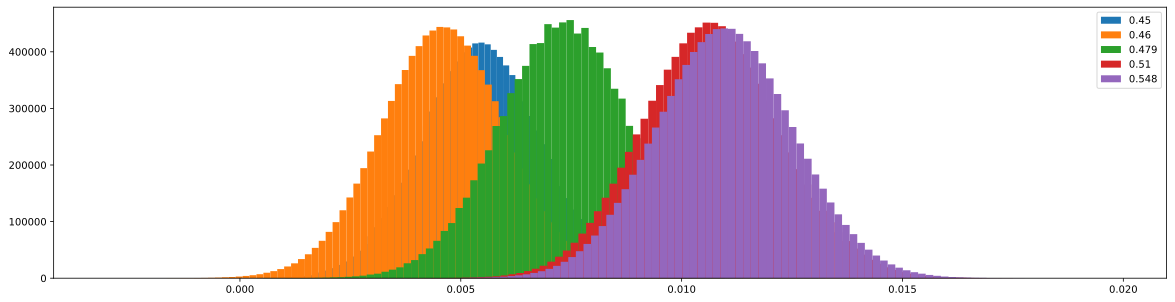

In [ ]:
def plot_histograms(x):

    y1, x1, S1 = RTxReadBin(ds11_files[x])
    y2, x2, S2 = RTxReadBin(ds11_files[x+1])
    y3, x3, S3 = RTxReadBin(ds11_files[x+2])
    y4, x4, S4 = RTxReadBin(ds11_files[x+3])
    y5, x5, S4 = RTxReadBin(ds11_files[x+4])
    
    plt.figure(figsize= [20,5])
    plt.hist(y1.flat[0:10000000], bins=100, label=ds9_mA[x])
    plt.hist(y2.flat[0:10000000]-offset, bins=100, label=ds9_mA[x+1])
    plt.hist(y3.flat[0:10000000]-offset, bins=100, label=ds9_mA[x+2])
    plt.hist(y4.flat[0:10000000]-offset, bins=100, label=ds9_mA[x+3])
    plt.hist(y5.flat[0:10000000]-offset, bins=100, label=ds9_mA[x+4])
    plt.legend()
    
    print('Current', ds9_mA[x], ' Skewness :',stats.skew(y1), ' Kurtosis :', stats.kurtosis(y1) )
    print('Current', ds9_mA[x+1], ' Skewness :',stats.skew(y2), ' Kurtosis :', stats.kurtosis(y2) )
    print('Current', ds9_mA[x+2], ' Skewness :',stats.skew(y3), ' Kurtosis :', stats.kurtosis(y3) )
    print('Current', ds9_mA[x+3], ' Skewness :',stats.skew(y4), ' Kurtosis :', stats.kurtosis(y4) )
    print('Current', ds9_mA[x+4], ' Skewness :',stats.skew(y5), ' Kurtosis :', stats.kurtosis(y5) )

plot_histograms(17)

Current 0.713  Skewness : [[-0.00182324]]  Kurtosis : [[0.04888391]]
Current 0.901  Skewness : [[2.3946082e-05]]  Kurtosis : [[0.00858736]]
Current 1.203  Skewness : [[-0.01765775]]  Kurtosis : [[0.01164794]]
Current 1.5  Skewness : [[-0.04155787]]  Kurtosis : [[0.03426838]]
Current 1.752  Skewness : [[-0.11798953]]  Kurtosis : [[-0.01656365]]


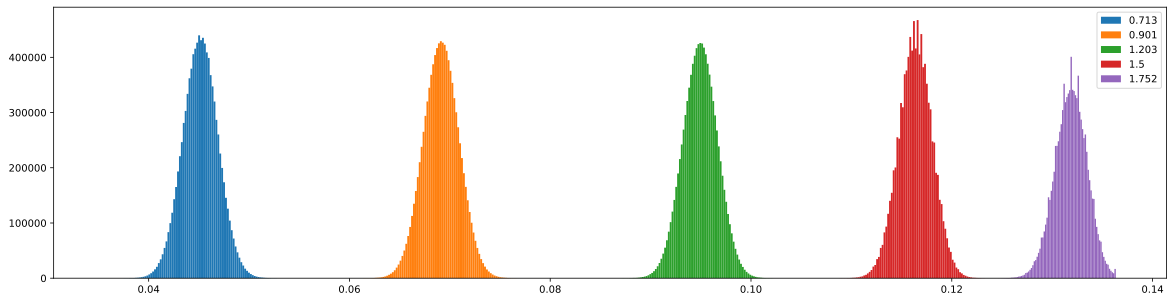

In [ ]:
plot_histograms(19)

In [ ]:
fig = plt.figure(figsize= [20,5])
plt.hist(offset_yb.flat[0:10000000], bins=100)
plt.hist(offset_y.flat[0:10000000], bins=100)

NameError: name 'offset_yb' is not defined

<Figure size 1440x360 with 0 Axes>